## Import Libraries

In [1]:
import sys
import os
sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

os.chdir('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from skimage import io, color
from utils.utils import set_global_seed
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
set_global_seed(42)

/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
np.mean([30.97,31.14])

31.055

## Set Directories

In [2]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Create Model

### Swin2SR

In [3]:
from tests.training import Swin2SRModule
from configs.biosr_config import get_config
import json

model_directory = '/group/jug/Michele/training/2411/hagen/0/'
config_fpath = os.path.join(model_directory,'config.json')
with open(config_fpath,'rb') as f:
    config = json.load(f)

# Initialize the model
model = Swin2SRModule(config)

model.load_state_dict(torch.load(os.path.join(model_directory,'jo0yqte5swin2sr_best.ckpt'))['state_dict'])

<All keys matched successfully>

## Stitching Predictions


In [4]:
data_type = 'hagen'
gauss_factor = 0
poisson_factor = 0
noisy_data = False
patch_size = 256
tile_size = 128

data_shape = (10, 2048, 2048) 

In [5]:
from predtiler.dataset import get_tiling_dataset, get_tile_manager
from data_loader.biosr_dataloader import SplitDataset

manager = get_tile_manager(data_shape=data_shape, tile_shape=(1,tile_size,tile_size), 
                               patch_shape=(1,patch_size,patch_size))

    
dset_class = get_tiling_dataset(SplitDataset, manager)
dataset = dset_class(           data_type = data_type,
                                patch_size=patch_size,
                                transform=None,
                                noisy_data=noisy_data,
                                noise_factor=poisson_factor, 
                                gaus_factor=gauss_factor,
                                mode = 'Test'
                                )
print(type(dataset))
test_loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=4)
c1_min, c1_max, c2_min, c2_max = test_loader.dataset.get_normalization_params() #of the entire dataset

Norm Param:  46.0 42.0 1993.0 1993.0 3986.0 129.0
c1_data shape: (2048, 2048, 10)
c2_data shape: (2048, 2048, 10)
<class 'predtiler.dataset.get_tiling_dataset.<locals>.TilingDataset'>


In [6]:
print(manager)

TileIndexManager(data_shape=(10, 2048, 2048), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)


In [7]:
print(len(test_loader))

1125


In [8]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
model = model.eval()
model = model.cuda()
inputs = []

for inp, targ in test_loader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    pred = model(inp)
    
    
    pred[:,0,:,:] = pred[:,0,:,:]*(c1_max - c1_min) + c1_min
    pred[:,1,:,:] = pred[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    predictions.append(pred.cpu().detach().numpy())
    
    
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    inputs.append(inp.cpu().detach().numpy())
    targets.append(targ.cpu().detach().numpy())

inputs = np.concatenate(inputs, axis = 0)
predictions = np.concatenate(predictions, axis = 0) # shape: (number_of_patches, C, patch_size, patch_size)
stitched_pred = stitch_predictions(predictions, dataset.tile_manager)
targets = np.concatenate(targets, axis = 0)
print(targets.shape)
print(manager)
print(predictions.shape)
print(stitched_pred.shape)

[10, 2048, 2048, 2]
(2250, 2, 256, 256)
TileIndexManager(data_shape=(10, 2048, 2048), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)
(2250, 2, 256, 256)
(10, 2048, 2048, 2)


In [9]:
from data_loader.biosr_no_patching import NoPatchingSplitDataset
dataset_no_patching = NoPatchingSplitDataset(
                              data_type=data_type,
                              transform=None,
                              noisy_data=noisy_data,
                              noise_factor= poisson_factor, 
                              gaus_factor= gauss_factor, mode = 'Test')


dataloader = DataLoader(dataset_no_patching, batch_size=2, shuffle=False, num_workers=4)
c1_min, c1_max, c2_min, c2_max = test_loader.dataset.get_normalization_params() #of the entire dataset

Norm Param:  46.0 42.0 1993.0 1993.0 3986.0 129.0
c1_data shape: (2048, 2048, 10)
c2_data shape: (2048, 2048, 10)


In [10]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
targets = []
inputs = []

for inp, targ in dataloader:
    inp, targ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)
    if len(targ.shape) == 3:
        targ = targ.unsqueeze(1)        
    targ[:,0,:,:] = targ[:,0,:,:]*(c1_max - c1_min) + c1_min
    targ[:,1,:,:] = targ[:,1,:,:]*(c2_max - c2_min) + c2_min
    
    targets.append(targ.cpu().detach().numpy())
    inputs.append(inp.cpu().detach().numpy())
    
inputs = np.concatenate(inputs, axis = 0)
targets = np.concatenate(targets, axis = 0)
print(targets.shape)

(10, 2, 2048, 2048)


In [11]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
for ch_idx in range(targets.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
        
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(targets[:,ch_idx,:,:], stitched_pred[:,:,:,ch_idx], range_= data_range))

print(psnr_arr)
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))


{0: [tensor([32.6713, 30.7411, 34.1212, 28.3337, 32.3294, 33.1736, 30.2350, 31.2704,
        29.1700, 29.3526])], 1: [tensor([32.4021, 30.5809, 33.6434, 28.4868, 32.1616, 32.9580, 30.1830, 31.2113,
        28.9705, 29.0853])]}
psnr channel 1: 31.139837
psnr channel 2: 30.968288


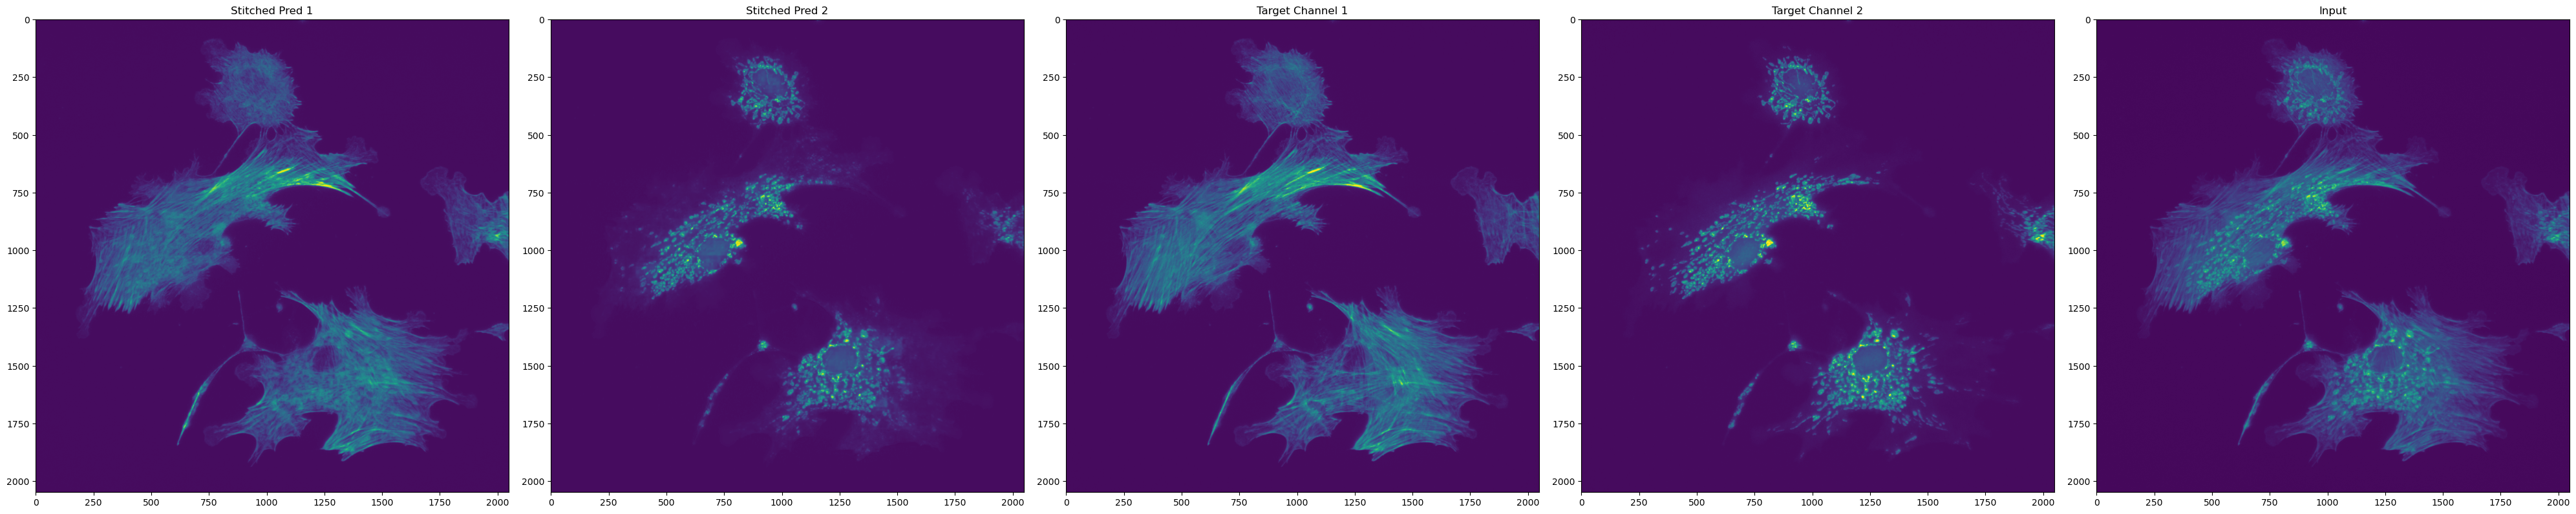

In [12]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(40, 50))  # 1 riga, 2 colonne

_, target = dataloader.dataset[0]


# Primo subplot
ax1.imshow(stitched_pred[0,:,:,0],vmin = targets[0,0,:,:].min())
ax1.set_title('Stitched Pred 1')

# Secondo subplot
ax2.imshow(stitched_pred[0,:,:,1],vmin = targets[0,1,:,:].min())
ax2.set_title('Stitched Pred 2')

# Secondo subplot
ax3.imshow(targets[0,0,:, :])
ax3.set_title('Target Channel 1')


# Secondo subplot
ax4.imshow(targets[0,1,:,:])
ax4.set_title('Target Channel 2')


# Secondo subplot
ax5.imshow(inputs[0,0,:,:])
ax5.set_title('Input')


# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()

In [13]:
print(targets[:, 0, :, :].max())
print(stitched_pred[:, 0,:, :].max())
print(targets[:, 0, :, :].min())
print(stitched_pred[:, 0,:, :].min())

1993.0
1689.9678
46.0
96.66114


In [14]:
directory = '/group/jug/ashesh/TrainValTestSplit/hagen'
val = np.load(os.path.join(directory, 'val_data.npy'), allow_pickle=True)
print(val.shape)
train = np.load(os.path.join(directory, 'train_data.npy'), allow_pickle=True)
print(train.shape)
print(train.min(), val.min(), train.max(), val.max())

(10, 2048, 2048, 2)
(80, 2048, 2048, 2)
22.0 38.0 40148.0 7940.0


In [15]:
percentile = np.percentile(train, 99.5)
clipped = np.clip(train, None, percentile)

In [16]:
print(1e-3)

0.001


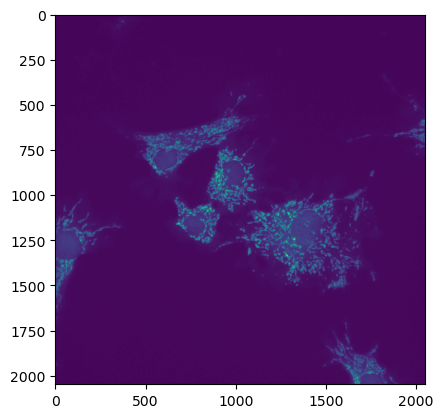

In [17]:
plt.imshow(train[0,:,:,1])

In [18]:
print()